In [1]:
from datetime import datetime
import tensorflow_addons as tfa
from model import *
from util import *
import numpy as np
from TrainMonitor import *
from WarmUpCosine import *

c:\python\python38\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Dataset

In [9]:
data['data'].shape

(1140, 11, 3000)

In [3]:
# "RESP PTAF",  # 10
# "RESP AIRFLOW",  # 11
# "RESP THORACIC",  # 12
# "RESP ABDOMINAL",  # 13
# "SPO2",  # 14
# "RATE",  # 15
# "CAPNO",  # 16
# "RESP RATE",  # 17

In [4]:
x[0].shape

(1396, 3840, 21)

In [5]:
x = x[0]

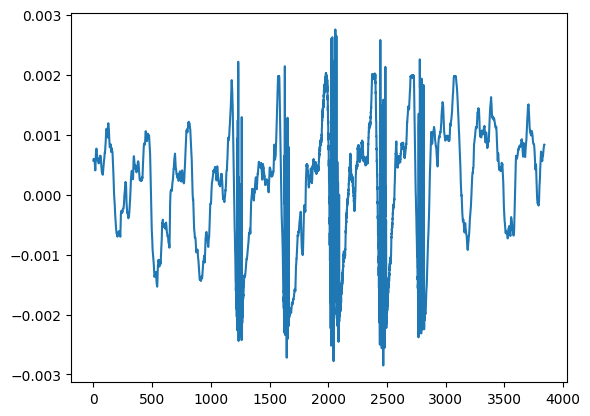

In [9]:
low = 0
high = 3840
ran = range(high - low)
plt.plot(ran, x[80, low:high, 10])
plt.show()

In [56]:
from scipy import signal

data_path = "D:\\nch_30x128_test.npz"
data = np.load(data_path, allow_pickle=True)
x, y_apnea, y_hypopnea = data['x'], data['y_apnea'], data['y_hypopnea']

xx = np.zeros((x.shape[0], 129, 31, 1))
for i in range(x.shape[0]):
    f, t, Zxx = signal.stft(x[i, :, 5], fs=128, padded=False)
    xx[i, :, :, 0] = Zxx
    #plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    #plt.show()

C:\Users\hamed\AppData\Local\Temp\ipykernel_18372\1659176334.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  xx[i, :, :, 0] = Zxx


In [57]:
xx.shape

(1396, 129, 31, 1)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = ((x_train[:40000], y_train[:40000]), (x_train[40000:], y_train[40000:]),)

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

In [4]:
val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

In [5]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Model

In [6]:
keras.backend.clear_session()

mae_model = MaskedAutoencoder(train_augmentation_model=get_train_augmentation_model(),
                              test_augmentation_model=get_test_augmentation_model(),
                              patch_layer=PatchesPre(), patch_encoder=PatchEncoderPre(),
                              encoder=create_encoder(), decoder=create_decoder(), )


# Training

In [7]:
total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_steps = int(total_steps * 0.15)
scheduled_lrs = WarmUpCosine(learning_rate_base=LEARNING_RATE, total_steps=total_steps, warmup_learning_rate=0.0,
                             warmup_steps=warmup_steps, )

timestamp = datetime.utcnow().strftime("%y%m%d-%H%M%S")
train_callbacks = [
    keras.callbacks.TensorBoard(log_dir=f"mae_logs_{timestamp}")]  #,TrainMonitor(test_ds, epoch_interval=5),]

optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
mae_model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"])
# mae_model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3), output_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
# mae_model.summary()
history = mae_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks, )

Epoch 1/10
140/157 [=========================>....] - ETA: 0s - loss: 0.0491 - mae: 0.1775


KeyboardInterrupt



In [5]:
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

40/40 [==============================] - 1s 17ms/step - loss: 0.0201 - mae: 0.1032
Loss: 0.02
MAE: 0.10


# Downstrean Task

In [6]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model
# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.
# Extract the encoder.
encoder = mae_model.encoder
# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing)
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_pre (PatchesPre)    (None, 64, 108)           0         
                                                                 
 patch_encoder_pre (PatchEnc  (None, 64, 128)          22252     
 oderPre)                                                        
                                                                 
 mae_encoder (Functional)    (None, None, 128)         990976    
                                                                 
 batch_normalization (BatchN  (None, 64, 128)          512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                

In [7]:
train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [8]:
linear_probe_epochs = 5  #TODO: 20
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(learning_rate_base=linear_prob_lr, total_steps=steps, warmup_learning_rate=0.0,
                             warmup_steps=warmup_steps, )
optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/5
157/157 [==============================] - 10s 54ms/step - loss: 1.9531 - accuracy: 0.3090 - val_loss: 1.8220 - val_accuracy: 0.3513
Epoch 2/5
157/157 [==============================] - 8s 50ms/step - loss: 1.7902 - accuracy: 0.3605 - val_loss: 1.7597 - val_accuracy: 0.3692
Epoch 3/5
157/157 [==============================] - 9s 54ms/step - loss: 1.7448 - accuracy: 0.3782 - val_loss: 1.7036 - val_accuracy: 0.3939
Epoch 4/5
157/157 [==============================] - 8s 52ms/step - loss: 1.7129 - accuracy: 0.3945 - val_loss: 1.6764 - val_accuracy: 0.4105
Epoch 5/5
40/40 [==============================] - 1s 24ms/step - loss: 1.6721 - accuracy: 0.4111
Accuracy on the test set: 41.11%.


In [9]:
downstream_model.save(f"linear_probe_{timestamp}", include_optimizer=False)

INFO:tensorflow:Assets written to: linear_probe_230623-164625\assets


INFO:tensorflow:Assets written to: linear_probe_230623-164625\assets
